<a href="https://colab.research.google.com/github/Shakpro10/Machine-Learning-Projects/blob/main/Time%20Series%20Analysis/Temperature%20prediction%20using%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import packages**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

## **Get dataset**

In [2]:
path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(path)

In [3]:
df = pd.read_csv(path) # Read csv
df.head() # Display the first-five rows

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df = df[5::6] # Display the hourly data
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [5]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S') # Convert to datetime
df = df.drop(columns=['Date Time']) # Drop datetime column
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


<Axes: xlabel='Date Time'>

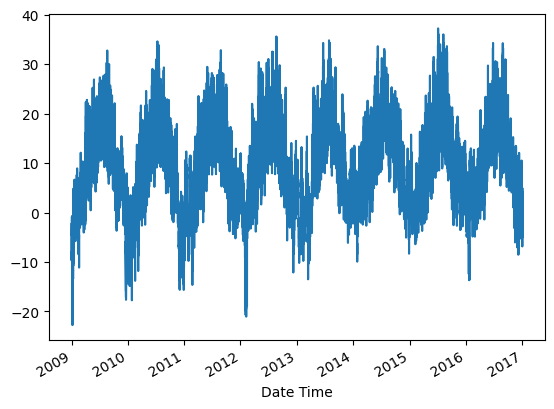

In [6]:
df['T (degC)'].plot() # Plot of the temperature column

In [7]:
df.isna().sum()

,0
p (mbar),0
T (degC),0
Tpot (K),0
Tdew (degC),0
rh (%),0
VPmax (mbar),0
VPact (mbar),0
VPdef (mbar),0
sh (g/kg),0
H2OC (mmol/mol),0


## **Function to create sliding window**

In [8]:
def df_to_x_y(df, window_size=1):
  df_to_np = df.values # Convert dataframe to numpy array

  x = [] # Initialise empty list for input
  y = [] # Initialise empty list for label

  # Create sliding window
  for i in range(len(df_to_np) - window_size):
    input = [[a] for a in df_to_np[i:i+window_size]] # Window of data (input features)
    label = df_to_np[i+window_size] # Next value after window (label)
    x.append(input)
    y.append(label)

  return np.array(x), np.array(y)  # Convert to numPy arrays

In [9]:
window_size = 5
x, y = df_to_x_y(df['T (degC)'], window_size) # Call the function to get x and y
x.shape, y.shape

((70086, 5, 1), (70086,))

## **Split data into training, validation and testing**

In [10]:
train_size = int(len(x) * .8) # 80% of data for training
p_90 = int(len(x) * .9) # 90% of data

x_train, y_train = x[:train_size], y[:train_size] # Training data
x_val, y_val = x[train_size:p_90], y[train_size:p_90] # Validation data
x_test, y_test = x[p_90:], y[p_90:] # Testing data

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((56068, 5, 1), (56068,), (7009, 5, 1), (7009,), (7009, 5, 1), (7009,))

## **Model development**

In [11]:
model = Sequential() # Initialize the sequential model
model.add(InputLayer((5, 1))) # Input layer
model.add(LSTM(64)) # LSTM layer
model.add(Dense(8, activation='relu')) # Hidden layer
model.add(Dense(1)) # Output layer
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
checkpoint = ModelCheckpoint('model1.keras', save_best_only=True, monitor='val_loss', mode='min') # Save best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early stopping checkpoint

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) # Model compilation

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[checkpoint, early_stopping]) # Model training

Epoch 1/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 72.7753 - root_mean_squared_error: 8.2844 - val_loss: 4.9898 - val_root_mean_squared_error: 2.2338
Epoch 2/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.5309 - root_mean_squared_error: 1.5856 - val_loss: 1.5307 - val_root_mean_squared_error: 1.2372
Epoch 3/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.0280 - root_mean_squared_error: 1.0135 - val_loss: 0.9634 - val_root_mean_squared_error: 0.9815
Epoch 4/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.7805 - root_mean_squared_error: 0.8832 - val_loss: 0.7713 - val_root_mean_squared_error: 0.8783
Epoch 5/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.6911 - root_mean_squared_error: 0.8313 - val_loss: 0.7171 - val_root_mean_squared_error: 0.8468
Epoch 6/50
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.6753 - root_mean_squared_error: 0.8215 - val_loss: 0.6753 - val_root_mean_squared_error: 0.8217
Epoch 7/50
1753/1753 ━━━━━━━━━━━━━

## **Create a function for train, validation and test plots**

In [13]:
def plot_predictions(model, x, y, start, stop):
  y_pred = model.predict(x).flatten() # Make predictions
  df = pd.DataFrame(data={'Predictions': y_pred, 'Actuals': y}) # Create dataframe of predictions and actual label
  plt.plot(df.Predictions[start:stop], label='Predictions') # Plot predictions
  plt.plot(df.Actuals[start:stop], label='Actuals') # Plot actuals
  plt.title("Model Predictions vs Actual") # Title
  plt.xlabel("Number of Periods") # X-label
  plt.ylabel("Values") # Y-label
  plt.grid() # Display grid
  plt.legend() # Display legend
  plt.show() # Display plot
  return df, mse(y, y_pred), mae(y, y_pred) # Return the dataframe, means_quared_error and mean_absolute_error

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


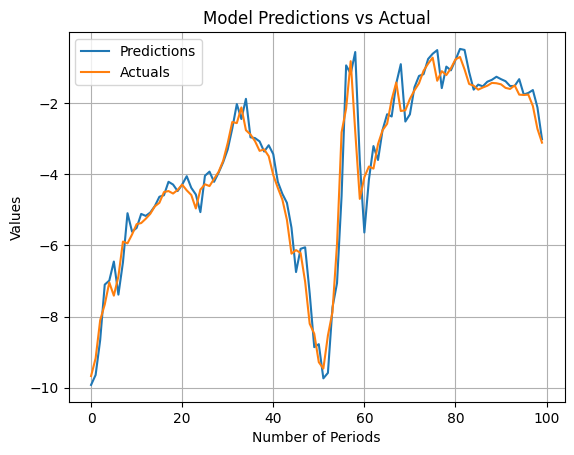

(       Predictions  Actuals
 0        -9.919552    -9.67
 1        -9.638583    -9.17
 2        -8.657281    -8.10
 3        -7.100325    -7.66
 4        -6.986748    -7.04
 ...            ...      ...
 56063    17.626303    17.77
 56064    18.151649    19.40
 56065    20.226254    19.03
 56066    19.033890    18.46
 56067    18.067656    17.93
 
 [56068 rows x 2 columns],
 0.6178389737158906,
 0.5269766466048715)

In [17]:
plot_predictions(model, x_train, y_train, start=0, stop=100) # Train plot

220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


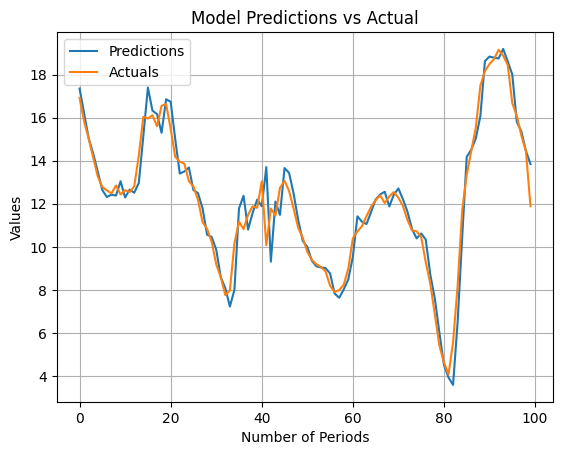

(      Predictions  Actuals
 0       17.349564    16.92
 1       16.195923    15.82
 2       15.040323    15.02
 3       14.321879    14.14
 4       13.482274    13.26
 ...           ...      ...
 7004     2.775452     2.93
 7005     2.772129     2.29
 7006     2.068095     2.48
 7007     2.453175     2.77
 7008     2.959930     2.80
 
 [7009 rows x 2 columns],
 0.61556616158582,
 0.5292631991306034)

In [18]:
plot_predictions(model, x_val, y_val, start=0, stop=100) # Validation plot

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


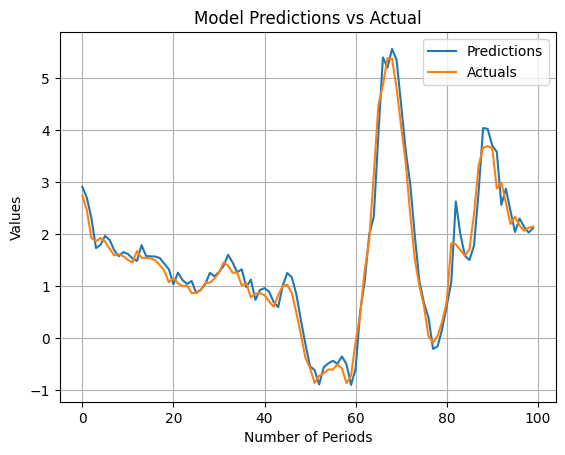

(      Predictions  Actuals
 0        2.914977     2.75
 1        2.704384     2.46
 2        2.311597     1.93
 3        1.737559     1.87
 4        1.801085     1.93
 ...           ...      ...
 7004    -1.018647    -0.98
 7005    -1.475264    -1.40
 7006    -1.639220    -2.75
 7007    -3.180746    -2.89
 7008    -3.096840    -3.93
 
 [7009 rows x 2 columns],
 0.5976600703379982,
 0.529410944195481)

In [19]:
plot_predictions(model, x_test, y_test, start=0, stop=100) # Test plot